✍ В предыдущем юните мы говорили о том, что полиномиальная регрессия склонна к переобучению. Это связано со сложностью модели и её способностью подстраиваться под очень сложные зависимости, из-за которых возникает высокий разброс.

Рассмотрим пример ↓

Обучим модель полиномиальной регрессии третьей степени. Будем использовать данные о жилье в Бостоне и возьмём следующие четыре признака: LSTAT, CRIM, PTRATIO и RM.

Для оценки качества модели будем использовать кросс-валидацию и сравнивать среднее значение метрики на тренировочных и валидационных фолдах. Кросс-валидацию организуем с помощью функции cross_validate из модуля model_selection:

In [1]:
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

В качестве метрики используем среднюю абсолютную процентную ошибку — MAPE.

In [2]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
boston_data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)

boston_data[['CHAS', 'LSTAT', 'CRIM','RM']].describe()

X = boston_data[['LSTAT', 'PTRATIO', 'RM', 'CRIM']]
y = boston_data[['PRICE']]

poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

lr = LinearRegression()

cv_results = cross_validate(lr, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(abs(cv_results['train_score'].mean()* 100)))
print('MAPE на валидационных фолдах: {:.2f} %'.format(abs(cv_results['test_score'].mean() * 100)))	
 
## MAPE на тренировочных фолдах: 12.64 %
## MAPE на валидационных фолдах: 24.16 %

MAPE на тренировочных фолдах: 12.64 %
MAPE на валидационных фолдах: 24.16 %


In [3]:
cv_results

{'fit_time': array([0.01401258, 0.00154829, 0.00199199, 0.00246763, 0.00200295]),
 'score_time': array([0.00213385, 0.00127721, 0.00200844, 0.00199461, 0.00151563]),
 'test_score': array([-0.09343344, -0.33040328, -0.09049194, -0.26870011, -0.42477462]),
 'train_score': array([-0.14347924, -0.13090978, -0.13977396, -0.10890062, -0.10875258])}

Что мы видим? Даже при, казалось бы, небольшой, третьей степени полинома мы получили переобучение: на тренировочной выборке $MAPE=12.64 \%$, а вот на тестовой — $MAPE=24.16 \%$. Показатели качества отличаются практически в два раза, что говорит о высоком разбросе модели. Ещё более удручающий результат мы получим, если воспользуемся полиномом большей степени (при желании вы можете проверить это самостоятельно).

Как с этим справиться, мы тоже уже знаем.

* Можно попробовать понизить сложность модели (снизить степень полинома). Но до какой степени? Можно постепенно перебирать степень полинома до тех пор, пока не получим адекватные результаты, но, согласитесь, процедура не очень приятная.
* Можно воспользоваться методами регуляризации.

О втором способе как раз и поговорим подробнее с математической точки зрения.

Для начала вспомним, что такое **регуляризация.**

>**Регуляризация** — это способ уменьшения переобучения моделей машинного обучения путём намеренного увеличения смещения модели для уменьшения её разброса.

Регуляризация для линейной регрессии преследует сразу несколько целей. Однако далее мы увидим, что все эти цели на самом деле взаимосвязаны:

* предотвратить переобучение модели;
* включить в функцию потерь штраф за переобучение;
* обеспечить существование обратной матрицы $(A^T A)^{-1}$;
* не допустить огромных коэффициентов модели.

→ Мы знаем, что большие значения весов — прямое свидетельство переобучения модели линейной регрессии и её нестабильности. Идея регуляризации состоит в наложении ограничения на вектор весов (часто говорят — наложение штрафа за высокие веса). В качестве штрафа принято использовать **норму вектора весов.**

Давайте запишем это на языке линейной алгебры. Вот задача минимизации длины вектора ошибок, о которой мы говорили, когда выводили формулу МНК:

$$\left\|\vec{y} - A\vec{w} \right\|^2 \rightarrow min,$$

где $\vec{y}$ — вектор истинных ответов, $A$ — матрица наблюдений, $\vec{w}$ — вектор весов линейной регрессии $\vec{w}=(w_0, w_1, w_2, …, w_k)^T$.

Вот её приближённое решение по МНК:

$$\vec{w}=\left(A^{T} A\right)^{-1} A^{T} \vec{y}$$

Теперь в исходную задачу оптимизации добавим ограничение на норму вектора весов — она не должна превышать некоторого заранее заданного $b$:

$$\left\{\begin{array}{c} \|\vec{y}-A \vec{w}\|^2 \rightarrow \min \\ \left(\|\vec{w}\|_{L_p}\right)^p \leq b \end{array}\right.$$

где $\left\|\vec{w} \right\|_{L_{p}}$ — норма вектора порядка , которая определяется как:

>**Примечание.** Обратите внимание на сумму под знаком корня. У нас она начинается с $i=0$. Однако иногда в литературе, например **[здесь](https://dyakonov.org/2019/10/31/%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F/)**, можно встретить $i=1$, то есть свободный член  рекомендуется не регуляризировать (не ограничивать). На самом деле это утверждение эвристическое и может как выполняться, так и нет, в зависимости от особенностей реализации. Мы будем придерживаться реализации в sklearn, в которой   всё-таки включается в регуляризацию. 

Порядок нормы $p$ в общем случае может быть любой — главное, чтобы она была больше 1. Однако на практике распространены только первая и вторая степени, так называемые $L_1$- и $L_2$-**регуляризации**. О них мы поговорим ниже, а пока доведём решение задачи до конца и получим общую формулу.

Поставленная задача оптимизации называется **условной** — мы ищем минимум при некотором условии. Мы ещё не умеем решать такие задачи, но обязательно научимся, а пока на минутку заглянем в теорию оптимизации и поговорим о **методе множителей Лагранжа**. Прелесть данного метода в том, что он позволяет свести условную задачу оптимизации к безусловной, то есть благодаря Лагранжу мы можем перейти от системы к одному уравнению.

Метод множителей Лагранжа говорит, что записанная система с ограничением эквивалентна следующей записи:

$$L(\vec{w}, \alpha)=\|\vec{y}-A \vec{w}\|^{2}+\alpha\left(\|\vec{w}\|_{L_{p}}\right)^{p} \rightarrow \min,$$

где $L(\vec{w}, \alpha)$ — функция Лагранжа, которая зависит не только от вектора весов модели $\vec{w}$, но и от некоторой константы $\alpha \geq 0$ — множителя Лагранжа.

Это и есть финальный результат, на котором мы пока что остановимся. По сути, ничего особо не изменилось по сравнению с изначальной задачей оптимизации. Добавилось только одно слагаемое — $\alpha ( \| \vec{w} \|_{L_{p}})^p$. Заметим, что если $\alpha = 0$, то мы получаем исходную задачу $\| \vec{y} - A\vec{w}  \|^2  \rightarrow min$. Далее мы увидим, что это маленькое слагаемое очень сильно поможет нам победить переобучение модели.

В машинном обучении множитель Лагранжа  принято называть **коэффициентом регуляризации**. Он отвечает за «силу» регуляризации. Чем он больше, тем меньшие значения может принимать слагаемое $\ {\left({‖\overrightarrow{w}‖}_{L_p}\right)}^p$, то есть тем сильнее ограничения на норму весов. В этом и была наша цель — ограничить веса.

Теперь разберёмся с **частными случаями.**

## **<center>L_2-РЕГУЛЯРИЗАЦИЯ**

Начнём мы, как ни странно, с $L_2$-регуляризации, так как она очень наглядно показывает, как регуляризация обеспечивает невырожденность матрицы $A^T A$.

$L_2$-**регуляризация (Ridge)**, или **регуляризация по Тихонову** — это регуляризация, в которой порядок нормы $p=2$. 

Тогда, если подставить $p=2$ в наши формулы, то оптимизационная задача в случае $L_2$-регуляризации будет иметь вид:

$${‖\overrightarrow{w}‖}_{L_2}=\sqrt[2]{\sum^k_{i=0}{}{|w}_i{|}^2=}\sqrt{\sum^k_{i=0}{}{(w}_i)^2}\$$
$$\left\{\begin{array} { c } { \| \vec { y } - A \vec { w } \| ^ { 2 } \rightarrow \operatorname { m i n } } \\ { ( \| \vec { w } \| _ { L _ { 2 } } ) ^ { 2 } \leq b } \end{array} \leftrightarrow \left\{\begin{array}{c} \|\vec{y}-A \vec{w}\|^2 \rightarrow \min \\ \sum_{i=0}^k\left(w_i\right)^2 \leq b \end{array}\right.\right.$$

**Примечание.** Видно, что норма порядка $p=2$ на самом деле является знакомой нам длиной вектора. То есть в случае $L_2$-регуляризации мы накладываем ограничение на длину вектора весов $\vec{w}$.

В терминах функции Лагранжа задача будет выглядеть как:

$${‖\overrightarrow{y}-A\overrightarrow{w}‖}^2+α\sum^k_{i=0}{}{(w}_i)^2→min$$

Как мы отметили ранее, у данной задачи даже есть аналитическое решение, полученное математиком Тихоновым, вот оно:

$${\widehat{\overrightarrow{w}}}_{ridge}={\left(A^TA+\alpha E\right)}^{-1}A^T \overrightarrow{y},$$

где $E$ — единичная матрица размера $dim (I) =(k+1, k+1)$ вида:

$$E=\left(\begin{array}{cccc} 1 & 0 & \ldots & 0 \\ 0 & 1 & \ldots & 0 \\ \ldots & \ldots & \ldots & \ldots \\ 0 & 0 & \ldots & 1 \end{array}\right)$$

>**Примечание.** В других реализациях аналитического решения регуляризации Тихонова, отличных от sklearn, где коэффициент $w_0$ не участвует в регуляризации, единичная матрица $E$ заменяется на матрицу $I$, в которой первый столбец и первая строка — нулевые. Это делается для того, чтобы исключить коэффициент $w_0$ из регуляризации:

$$I=\left(\begin{array}{cccc} 0 & 0 & \ldots & 0 \\ 0 & 1 & \ldots & 0 \\ \cdots & \cdots & \cdots & \cdots \\ 0 & 0 & \cdots & 1 \end{array}\right)$$

Что мы в итоге получаем? Преимущество этой формулы в том, что, если $\alpha >0$, то матрица $A^T A+\alpha E$ гарантированно является невырожденной, даже если матрица $A^T A$ таковой не является. Так получается за счёт того, что по диагонали матрицы $A^T A$ мы добавляем поправки, которые создают линейную независимость между столбцами матрицы.

Продемонстрируем это на **примере ↓**

?

**Пример № 1**

Построить линейную регрессию с $L_2$-регуляризацией, если:

$$\vec{x}_1=\left(\begin{array}{c} 1 \\ 0 \\ -3 \\ 2 \\ 4 \end{array}\right), \vec{x}_2=\left(\begin{array}{c} 2 \\ 0 \\ -6 \\ 4 \\ 8 \end{array}\right) \text { и } \vec{y}=\left(\begin{array}{c} 4 \\ 3 \\ -4 \\ 2 \\ 7 \end{array}\right)$$

Коэффициент регуляризации $a=5$.

Давайте составим матрицу наблюдений $A$ для нашей задачи:

$$A=\left(\begin{array}{ccc} 1 & 1 & 2 \\ 1 & 0 & 0 \\ 1 & -3 & -6 \\ 1 & 2 & 4 \\ 1 & 4 & 8 \end{array}\right)$$

Найдём матрицу Грама : 

$$A^T A=\left(\begin{array}{ccccc} 1 & 1 & 1 & 1 & 1 \\ 1 & 0 & -3 & 2 & 4 \\ 1 & 0 & -6 & 4 & 8 \end{array}\right)\left(\begin{array}{ccc} 1 & 1 & 2 \\ 1 & 0 & 0 \\ 1 & -3 & -6 \\ 1 & 2 & 4 \\ 1 & 4 & 8 \end{array}\right)=\left(\begin{array}{ccc} 5 & 4 & 8 \\ 4 & 30 & 60 \\ 8 & 60 & 120 \end{array}\right)$$

Очевидно, что матрица $A^T A$ вырождена: её второй и третий столбцы являются пропорциональными с коэффициентом 2. Значит, наша классическая формула МНК  (без сингулярного разложения) не сработает.

$$\widehat{\overrightarrow{w}}={\left(A^TA\right)}^{-1}A^T\overrightarrow{y}$$

Проверим:

In [4]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# получаем оценку коэффициентов регрессии по МНК
w_hat = np.linalg.inv(A.T@A)@A.T@y
print(w_hat) 
## LinAlgError: Singular matrix

LinAlgError: Singular matrix

Мы ожидаемо получили ошибку, говорящую о том, что матрица $A$ вырождена. 

Теперь попробуем воспользоваться регуляризацией Тихонова. Для этого составляем матрицу $E$. Она будет размером 3x3 (количество параметров — 3):

$$\alpha E=5\left(\begin{array}{lll} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{array}\right)=\left(\begin{array}{lll} 5 & 0 & 0 \\ 0 & 5 & 0 \\ 0 & 0 & 5 \end{array}\right)$$

Добавим регуляризационное слагаемое к матрице $A^T A$:

$$A^T A+a E=\left(\begin{array}{ccc} 5 & 4 & 8 \\ 4 & 30 & 60 \\ 8 & 60 & 120 \end{array}\right)+\left(\begin{array}{ccc} 5 & 0 & 0 \\ 0 & 5 & 0 \\ 0 & 0 & 5 \end{array}\right)=\left(\begin{array}{ccc} 10 & 4 & 8 \\ 4 & 35 & 60 \\ 8 & 60 & 125 \end{array}\right)$$

Видно, что матрица $A^T A+\alpha E$ уже не будет вырожденной: её столбцы уже не являются линейно зависимыми, а значит решение будет существовать.

Попробуем найти вектор оценок весов ${\widehat{\overrightarrow{w}}}_{ridge}$ по формуле:

In [5]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# единичная матрица
E = np.eye(3)
# коэффициент регуляризации 
alpha = 5
# получаем оценку коэффициентов регрессии по МНК с регуляризацией Тихонова
w_hat_ridge = np.linalg.inv(A.T@A+alpha*E)@A.T@y
print(w_hat_ridge) 
## [0.6122449  0.29387755 0.5877551 ]

[0.6122449  0.29387755 0.5877551 ]


Работает! Мы получили вектор весов:

$$\widehat{\overrightarrow{w}}={\left(0.61,\ 0.29,\ 0.59\right)}^T$$

Итак, мы посмотрели, как работает аналитическое решение $L_2$-регуляризации. Однако в реализации sklearn для решения этой задачи поддерживается сразу несколько методов — как численных (координатный спуск, градиентный спуск или **[LBFGS](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%91%D1%80%D0%BE%D0%B9%D0%B4%D0%B5%D0%BD%D0%B0_%E2%80%94_%D0%A4%D0%BB%D0%B5%D1%82%D1%87%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%93%D0%BE%D0%BB%D1%8C%D0%B4%D1%84%D0%B0%D1%80%D0%B1%D0%B0_%E2%80%94_%D0%A8%D0%B0%D0%BD%D0%BD%D0%BE)**), так и аналитических (классическая регуляризация Тихонова или она же через SVD-разложение). По умолчанию метод выбирается автоматически. На простых данных все методы будут показывать примерно одинаковые результаты при одном и том же значении коэффициента регуляризации, однако на реальных данных, когда данные не стандартизированы и присутствует сильная мультиколлинеарность между факторами, результат работы каждого из методов решения задачи оптимизации может значительно отличаться. Имейте это в виду при построении модели. Подробнее о методах вы можете прочитать в документации.

Напомним, что за реализацию линейной регрессии с $L_2$-регуляризацией в sklearn отвечает класс **[Ridge.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)** Основной параметр модели, на который стоит обратить внимание — alpha, коэффициент регуляризации из формулы Тихонова.

In [6]:
from sklearn.linear_model import Ridge

Давайте обучим модель для решения нашей последней задачи, а затем проверим коэффициенты регрессии. Так как мы заранее заложили в матрицу $A$ столбец из единиц, то, чтобы получить корректное решение, параметр fit_intercept следует установить в значение False.

In [7]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# получаем оценку коэффициентов регрессии по МНК с регуляризацией Тихонова
ridge = Ridge(alpha=5, fit_intercept=False)
ridge.fit(A, y)
print(ridge.coef_) 
## [0.6122449  0.29387755 0.5877551 ]

[0.6122449  0.29387755 0.5877551 ]


Получили тот же самый результат, что и раньше.

Наконец, посмотрим, как регуляризация поможет побороть переобучение модели полиномиальной регрессии на наборе данных о домах в Бостоне. Используем те же самые признаки: LSTAT, CRIM, PTRATIO и RM. 

→ Сразу отметим, что для успешной сходимости численных методов оптимизации, которые используются для решения задачи условной оптимизации, необходима стандартизация (нормализация) исходных данных, которая не требовалась для аналитического МНК в классической линейной регрессии (LinearRegression).

>**Примечание.** Здесь под **стандартизацией** мы понимаем именно приведение распределения признака к нулевому среднему и единичному стандартному отклонению (StandardScaler), а не стандартизацию векторов, о которой мы говорили в этом модуле. Последнюю также можно использовать в качестве способа масштабирования данных, однако её реализации нет в sklearn.

In [8]:
from sklearn.preprocessing import StandardScaler

Воспользуемся моделью полиномиальной регрессии третьей степени с регуляризацией Тихонова (коэффициент регуляризации возьмём равным 20) и проверим её качество на кросс-валидации по метрике MAPE.

In [9]:
# выделяем интересующие нас факторы
X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
# создаём модель линейной регрессии c L2-регуляризацией
ridge = Ridge(alpha, solver='svd')
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(ridge,X,y,scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))
## MAPE на тренировочных фолдах: 12.54 %
## MAPE на валидационных фолдах: 17.02 %

MAPE на тренировочных фолдах: 12.42 %
MAPE на валидационных фолдах: 18.76 %


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def MSE(y,y_pred):
    cost = np.sum((y-y_pred)**2)/len(y)
    return cost

def gradient_descent(x,y,iterations=1000,learning_rate=0.001,stopping_threshold=1e-3):
    
    current_bias = 0.01
    current_weight = 0.1
    learning_rate = learning_rate
    stopping_threshold = stopping_threshold
    
    
    n = float(len(x))
    cost_list = []
    weight_list = []
    previous_cost = None
    
    for i in range(iterations):
        
        y_pred = (current_weight * y) + current_bias
        
        current_cost = MSE(y,y_pred)
        
        if previous_cost and abs(previous_cost - current_cost) <= stopping_threshold:
            break
        
        previous_cost = current_cost
        
        cost_list.append(current_cost)
        weight_list.append(current_weight)
        
        weight_derivative =  -(2/n) * sum(x*(y -y_pred))
        bias_derivative = -(2/n) * sum(y-y_pred)
        
        current_weight = current_weight - (learning_rate * weight_derivative)
        current_bias = current_bias - (learning_rate * bias_derivative)
        
        print(f"Iteration {i+1}: Cost {current_cost}, Weight \
        {current_weight}, Bias {current_bias}")
        
    plt.figure(figsize = (8,6))
    plt.plot(weight_list, cost_list)
    plt.scatter(weight_list, cost_list, marker='o', color='red')
    plt.title("Cost vs Weights")
    plt.ylabel("Cost")
    plt.xlabel("Weight")
    plt.show()

Нам удалось уменьшить ошибку (MAPE) на валидационных фолдах кросс-валидации с 24.16% до 17.02% и сократить разницу в метриках, тем самым уменьшив разброс ответов модели.

Теперь перейдём к $L_2$-регуляризации.

**Задание 7.4**

Вычислите коэффициенты линейной регрессии с $L_2$-регуляризацией, используя аналитическую формулу Тихонова, если:

$$\vec{x}_1=\left(\begin{array}{l}
5 \\
9 \\
4 \\
3 \\
5
\end{array}\right), \vec{x}_2=\left(\begin{array}{l}
15 \\
18 \\
18 \\
19 \\
19
\end{array}\right), \vec{x}_3=\left(\begin{array}{l}
7 \\
6 \\
7 \\
7 \\
7
\end{array}\right) \text { и } \vec{y}=\left(\begin{array}{l}
24 \\
22 \\
35 \\
33 \\
36
\end{array}\right)$$

Коэффициент регуляризации $alpha = 1$.

В качестве ответа приведите значения полученных коэффициентов линейной регрессии, округлив их до второго знака после точки-разделителя.

In [11]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [5, 9, 4, 3, 5],
    [15, 18, 18, 19, 19],
    [7, 6, 7, 7, 7]
]).T
# вектор целевого признака
y = np.array([24, 22, 35, 33, 36])
# единичная матрица
E = np.eye(4)
# коэффициент регуляризации 
alpha = 1
# получаем оценку коэффициентов регрессии по МНК с регуляризацией Тихонова
w_hat_ridge = np.linalg.inv(A.T@A+alpha*E)@A.T@y
print(w_hat_ridge.round(2))

[-0.09 -1.71  1.91  0.73]


## **<center>L_1-РЕГУЛЯРИЗАЦИЯ**

>$L_1$-**регуляризацией, Lasso (Least Absolute Shrinkage and Selection Operator)**, называется регуляризация, в которой порядок нормы .

Тогда оптимизационная задача в случае $L_1$-регуляризации будет иметь вид:

$${‖\overrightarrow{w}‖}_{L_1}=\sqrt[1]{\sum^k_{i=0}{}{|w}_i{|}^1=}\sum^k_{i=0}{}{|w}_i|$$
$$\left\{\begin{array} { c } { \| \vec { y } - A \vec { w } \| ^ { 2 } \rightarrow \operatorname { m i n } } \\ { ( \| \vec { w } \| _ { 1 } ) ^ { 1 } \leq b } \end{array} \leftrightarrow \left\{\begin{array}{c} \|\vec{y}-A \vec{w}\|^2 \rightarrow \min \\ \sum_{i=0}^k\left|w_i\right| \leq b \end{array}\right.\right.$$

**Примечание.** Таким образом, в случае $L_1$-регуляризации мы ограничиваем сумму модулей весов модели. Такая величина называется **[нормой Манхэттена](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)** (расстоянием городских кварталов).

Запишем полученную систему в терминах метода Лагранжа:

$${‖\overrightarrow{y}-A\overrightarrow{w}‖}^2+α\sum^k_{i=0}{}{|w}_i|→min$$

→ Можно показать, что данная задача имеет аналитическое решение, однако в реализации sklearn оно даже не заявлено как возможное для использования в связи с нестабильностью взятия производной от функции модуля, поэтому мы не будем его рассматривать. Ознакомиться с ним вы можете **[здесь.](http://www.machinelearning.ru/wiki/images/7/7e/VetrovSem11_LARS.pdf)**

В sklearn $L_1$-регуляризация реализована в классе **[Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)**, а заданная выше оптимизационная задача решается **алгоритмом координатного спуска (Coordinate Descent).**

In [12]:
from sklearn.linear_model import Lasso

Давайте посмотрим, как работает Lasso на «игрушечном» примере, а затем применим его для набора данных о домах в Бостоне.

?

Пример № 2

Построить линейную регрессию с $L_1$-регуляризацией, если:

$$\vec{x}_1=\left(\begin{array}{c} 1 \\ 0 \\ -3 \\ 2 \\ 4 \end{array}\right), \vec{x}_2=\left(\begin{array}{c} 2 \\ 0 \\ -6 \\ 4 \\ 8 \end{array}\right) \text { и } \vec{y}=\left(\begin{array}{c} 4 \\ 3 \\ -4 \\ 2 \\ 7 \end{array}\right)$$

Коэффициент регуляризации $\alpha = 0.1$.

Составим матрицу наблюдений $A$ для нашей задачи:

$$A=\left(\begin{array}{ccc} 1 & 1 & 2 \\ 1 & 0 & 0 \\ 1 & -3 & -6 \\ 1 & 2 & 4 \\ 1 & 4 & 8 \end{array}\right)$$

Из примера №1 мы уже знаем, что матрица Грама $A^T A$ будет вырождена, а значит классического МНК-решения (не беря в расчёт сингулярное разложение) не получится.

Попробуем найти коэффициенты регрессии с помощью $L_1$-регуляризации. Для этого подадим нашу матрицу наблюдений $A$ и вектор целевого признака $\vec{y}$ в модель Lasso.

In [13]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# получаем оценку коэффициентов регрессии с помощью L1-регуляризации
lasso = Lasso(alpha=0.1, fit_intercept=False)
lasso.fit(A, y)
print(lasso.coef_)
## [1.14925373 0.         0.71921642]

[1.14925373 0.         0.71921642]


Вот наша оценка вектора весов:

→ Сразу обращаем внимание, что, в отличие от регуляризации Тихонова, $L_1$-регуляризация «занулила» коэффициент, стоящий при факторе ${\overrightarrow{x}}_1$. Это произошло не случайно, так как это особенность данного метода. Как говорится, «не баг, а фича», причём очень важная. Коэффициенты, стоящие при коллинеарных или высококоррелированных факторах, зануляются. Также чем выше коэффициент регуляризации, тем больше вероятность того, что коррелированные или малозначащие факторы будут исключены из модели. Чуть позже мы рассмотрим геометрическую интерпретацию и поймём, почему так происходит.

А пока давайте применим $L_1$-регуляризацию к нашей полиномиальной модели третьей степени, прогнозирующей типичную цену на дома в районах Бостона.

Так как метод координатного спуска, который применяется для поиска коэффициентов, является численным, то необходима стандартизация исходных данных, чтобы обеспечить ему сходимость. Возьмём в качестве коэффициента регуляризации $\alpha=0.1$ и проверим качество полученной модели с помощью кросс-валидации по метрике MAPE:

In [14]:
# выделяем интересующие нас факторы
X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]

# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)

# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# создаём модель линейной регрессии c L1-регуляризацией
lasso = Lasso(alpha=0.1, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))
## MAPE на тренировочных фолдах: 12.44 %
## MAPE на валидационных фолдах: 16.44 %

MAPE на тренировочных фолдах: 12.44 %
MAPE на валидационных фолдах: 16.44 %


Видим, что с помощью $L_1$-регуляризации удалось уменьшить ошибку модели (MAPE) на валидационных фолдах с 24.16% до 16.44% и сократить разницу в метриках на тренировочных и валидационных фолдах даже лучше, чем с этим справилась $L_2$-регуляризация. Однако на самом деле мы просто удачно выбрали коэффициент регуляр_изации — при других значениях могли получиться совершенно другие результаты.

### **<center>ELASTIC-NET**

Последний вид регуляризации (хотя их на самом деле больше), который мы рассмотрим, называется **Elastic-Net (эластичная сетка)**. Это комбинация $L_1$- и $L_2$-регуляризации.

Идея Elastic-Net состоит в том, что мы вводим ограничение как на норму весов порядка $p = 1$, так и на норму порядка $p = 2$. Тогда оптимизационная задача будет иметь вид:

$$\left\{\begin{array} { l } { \| \vec { y } - A \vec { w } \| ^ { 2 } \rightarrow \operatorname { m i n } } \\ { ( \| \vec { w } \| _ { L _ { 1 } } ) ^ { 1 } \leq b _ { 1 } } \\ { ( \| \vec { w } \| _ { L _ { 2 } } ) ^ { 2 } \leq b _ { 2 } } \end{array} \leftrightarrow \left\{\begin{array}{l} \|\vec{y}-A \vec{w}\|^2 \rightarrow \min \\ \sum_{i=0}^k\left|w_i\right| \leq b_1 \\ \sum_{i=0}^k\left(w_i\right)^2 \leq b_2 \end{array}\right.\right.$$

Немного модифицировав формулу функции Лагранжа, которая получается в результате такой задачи условной оптимизации, можно получить финальный результат:

$${\|\overrightarrow{y}-A\overrightarrow{w}\|}^2+\alpha \cdot \lambda \sum^k_{i=0}{}{|w}_i|+\frac{\alpha \cdot (1-\lambda )}{2}\sum^k_{i=0}{}{(w}_i)^2\to min$$

Здесь коэффициенты $\alpha$ и $\lambda$ отвечают за вклад слагаемых регуляризации.

* Если $\alpha=0$,  получаем классическую МНК-задачу оптимизации.
* Если $\alpha \neq 0$, $\lambda=1$, получаем Lasso-регрессию.
* Если $\alpha \neq 0$, $\lambda=0$, получаем Ridge-регрессию с коэффициентом $\frac{\alpha}{2}$.

Попробуйте самостоятельно подставить эти значения и убедиться в этом.

Аналитического решения у этой задачи нет, поэтому для её решения в sklearn, как и для модели Lasso, используется **координатный спуск.**

В sklearn эластичная сетка реализована в классе **[ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)** из пакета с линейными моделями — linear_model. За коэффициент $\alpha$ отвечает параметр alpha, за коэффициент $\lambda$ — l1_ratio.

Некоторые рекомендации от разработчиков ElasticNet:

* Использование параметра l1_ratio <0.01 приводит к нестабильным результатам.
* Вместо использования ElasticNet с alpha=0 лучше используйте LinearRegression, так как там применяется аналитическое решение, которое позволяет получать более точные решения, чем численный координатный спуск.


In [15]:
from sklearn.linear_model import ElasticNet


По традиции рассмотрим «игрушечный» пример работы с Elastic-Net, а затем применим эту модель к нашей задаче о домах в Бостоне.

?

**Пример № 3**

Построить линейную регрессию с **Elastic-Net**-регуляризацией, если:

$$\vec{x}_1=\left(\begin{array}{c} 1 \\ 0 \\ -3 \\ 2 \\ 4 \end{array}\right), \vec{x}_2=\left(\begin{array}{c} 2 \\ 0 \\ -6 \\ 4 \\ 8 \end{array}\right) \text { и } \vec{y}=\left(\begin{array}{c} 4 \\ 3 \\ -4 \\ 2 \\ 7 \end{array}\right)$$

Решить задачу с тремя комбинациями коэффициентов регуляризации:

1. $\alpha=0.1$, $\lambda=0.2$.
2. $\alpha=0.1$, $\lambda=0.7$.
3. $\alpha=0.1$, $\lambda=1$.

Составим матрицу наблюдений $A$ для нашей задачи:

$$A=\left(\begin{array}{ccc} 1 & 1 & 2 \\ 1 & 0 & 0 \\ 1 & -3 & -6 \\ 1 & 2 & 4 \\ 1 & 4 & 8 \end{array}\right)$$

Мы уже знаем, что матрица Грама $A^T A$ будет вырождена, а значит классического МНК-решения (не беря в расчёт сингулярное разложение) не получится.

Сразу переходим к построению регрессии с помощью ElasticNet.

**→ Случай 1**: $\alpha=0.1$, $\lambda=0.2$



In [16]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# получаем оценку коэффициентов регрессии 
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.2, fit_intercept=False)
elasticnet.fit(A, y)
print(elasticnet.coef_)
## [1.13492457 0.19525842 0.6237965 ]

[1.13492457 0.19525842 0.6237965 ]


Получили оценку вектора коэффициентов:

$${\widehat{\overrightarrow{w}}}_{en_1}={\left(1.13,\ 0.2,\ 0.62\right)}^T$$

Обратим внимание, что зануления коэффициентов коллинеарных факторов ${\overrightarrow{x}}_1$ и ${\overrightarrow{x}}_2$ не произошло. Каждый из них вошёл в уравнение регрессии с ненулевым коэффициентом.

**→ Случай 2**: $\alpha=0.1$, $\lambda=0.7$

In [17]:
# получаем оценку коэффициентов регрессии
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.7, fit_intercept=False)
elasticnet.fit(A, y)
print(elasticnet.coef_)
## [1.14379753 0.         0.71993025]

[1.14379753 0.         0.71993025]


Получили оценку вектора коэффициентов:

$${\widehat{\overrightarrow{w}}}_{en_2}={\left(1.14,\ 0,\ 0.72\right)}^T$$

Обратим внимание, что произошло зануление коэффициентов. Это неспроста, так как мы понизили влияние $L_2$-регуляризации и одновременно повысили влияние $L_1$-регуляризации, которая, как мы уже знаем, приводит к исключению линейно зависимых факторов.

**→ Случай 3:** $\alpha=0.1$, $\lambda=1$

In [18]:
# получаем оценку коэффициентов регрессии
elasticnet = ElasticNet(alpha=0.1, l1_ratio=1, fit_intercept=False)
elasticnet.fit(A, y)
print(elasticnet.coef_)
## [1.14925373 0.         0.71921642]

[1.14925373 0.         0.71921642]


Получили оценку вектора коэффициентов:

$${\widehat{\overrightarrow{w}}}_{en_3}={\left(1.15,\ 0,\ 0.72\right)}^T$$

В округлениях значения не заметно, однако если присмотреться к коэффициентам более внимательно, можно увидеть, что мы получили в точности те же значения, которые получали для модели Lasso в примере № 2. Неудивительно, ведь мы обнулили влияние $L_2$-регуляризации, выставив l1_ratio=1. По сути, мы использовали чистую модель Lasso.

**?**
Возникает вопрос: какой набор коэффициентов линейной регрессии всё-таки подходит лучше?

Ответить на него можно, только вычислив метрику качества и сравнив ошибки прогнозов каждой из полученных моделей. Мы уверены, вы можете сделать это самостоятельно.

Нам осталось только попробовать применить Elastic-Net к данным о недвижимости в Бостоне.

Как и для других моделей с регуляризацией, для Elastic-Net также лучше заранее позаботиться о стандартизации данных. В качестве коэффициентов регуляризации возьмём $\alpha=0.1$, $\lambda=0.5$ . Качество модели проверим с помощью кросс-валидации на пяти фолдах, метрика — MAPE.

In [19]:
# выделяем интересующие нас факторы
X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
# создаём модель линейной регрессии c L1- и L2-регуляризациями
lasso = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100)) 
## MAPE на тренировочных фолдах: 12.65 %
## MAPE на валидационных фолдах: 15.70 %

MAPE на тренировочных фолдах: 12.65 %
MAPE на валидационных фолдах: 15.70 %


Итак, Elastic-Net позволил нам уменьшить значение MAPE на валидационных фолдах с 24.16% до 15.7%. Отличный результат! Он получился лучше, чем у моделей Ridge и Lasso, но опять же скажем, что так бывает не всегда.

→ На практике при использовании моделей с регуляризацией стоит подбирать значения коэффициентов регуляризации с помощью методов подбора гиперпараметров, которые мы изучали в модуле «ML-7. Оптимизация гиперпараметров модели». Только после подбора гиперпараметров можно сделать вывод, какая из моделей показывает наилучшие результаты для решения конкретной задачи. Надеемся, вы помните, как подбираются гиперпараметры (если нет, освежите знания в модуле ML-7).

## **<center>ГЕОМЕТРИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ РЕГУЛЯРИЗАЦИИ**

Напоследок поговорим о геометрической интерпретации регуляризации. В дальнейшем, изучая теорию оптимизации, мы увидим, что задача условной оптимизации

$$\left\{\begin{array}{c} \|\vec{y}-A \vec{w}\|^2 \rightarrow \min \\ \left(\|\vec{w}\|_{L_p}\right)^p \leq b \end{array}\right.$$

геометрически означает поиск минимума функции $L(\overrightarrow{w})= \left\|\overrightarrow{y}-A\overrightarrow{w} \right\|^2=\sum^N_{i=1}{}(y_i-({\overrightarrow{x}}_i,\ \overrightarrow{w}))^2$, которая отражает выпуклую поверхность, на пересечении с фигурой, которая образуется функцией $\psi (\overrightarrow{w})=( \left\|\overrightarrow{w} \right\| _{L_p})^p$, ограниченной некоторым числом $b$.

В случае $L_1$-регуляризации выражение $\sum^k_{i=0}{}{|w}_i|\le b$ задаёт в пространстве параметров $w$ внутренность ромба с центром в начале координат:

$${|w}_0|+{|w}_1|+...+{|w}_k|=b — уравнение_ромба$$

В случае $L_2$-регуляризации выражение $\sum^k_{i=0}{}{(w}_i)^2\le b$ задаёт окружность с центром в начале координат:

$${(w}_0)^2+{(w}_1)^2+...+{(w}_k)^2=b — уравнение_окружности$$

Рассмотрим случай, когда фактор всего один (k=1), а в уравнении линейной регрессии присутствуют только два параметра: $w_0$ и $w_1$. Как мы знаем, в математике всё, что справедливо для меньших размерностей, справедливо и для бόльших.

Посмотрим на рисунок ниже. На самом деле мы уже видели его, когда изучали общую постановку задачи регрессии.

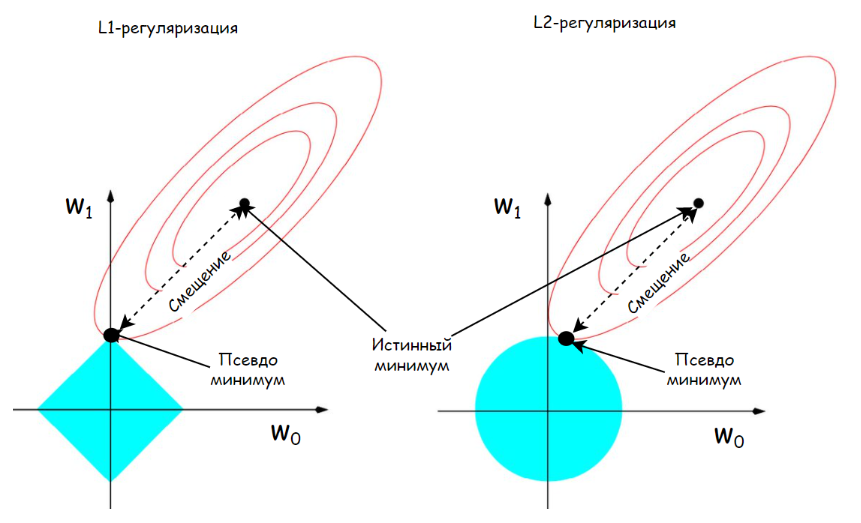

Концентрическими кругами обозначены линии равного уровня функции $L(w)$. Для каждого конкретного набора данных она будет иметь разный вид, но смысл будет тем же. **Голубой** областью обозначены ромб и окружность, которые задаёт $L_1$- и $L_2$-норма вектора весов соответственно.

* Если бы мы использовали классическую линейную регрессию, то МНК приводил бы нас в точку истинного минимума функции $L(w)$ — в центр, из которого исходят концентрические круги. Это была бы некоторая комбинация параметров $w_0$ и $w_1$.
* В случае, когда мы используем модель линейной регрессии с регуляризацией, мы будем пытаться найти такую комбинацию $w_0$ и $w_0$, которая доставляет минимум функции , но при этом не выходит за границы ромба (или окружности). Таким образом, вместо истинного минимума мы находим так называемый **псевдоминимум.**

Заметим, что у ромба вероятность коснуться концентрического круга одной из своих вершин больше, чем у окружности — своей верхней/нижней/правой/левой точкой. Точка касания в вершине ромба — это точка, в которой либо $w_0=0$ либо $w_1=0$. То есть $L_1$-регуляризация склонна с большей вероятностью занулять коэффициенты линейной регрессии, чем $L_1$-регуляризация.

Величина диагонали ромба и радиуса окружности зависят от величины коэффициента регуляризации $alpha$: чем больше $alpha$, тем меньше ромб/окружность, а значит тем дальше псевдоминимум будет находиться от истинного минимума, и наоборот.

In [20]:
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T

y = np.array([4, 3, -4, 2, 7])
#w = np.linalg.inv(A.T@A)@A.T@y


In [21]:
E = np.eye(3)
alpha = 5
w_ridge = np.linalg.inv(A.T@A +alpha*E)@A.T@y
display(w_ridge.reshape(3,1))

array([[0.6122449 ],
       [0.29387755],
       [0.5877551 ]])

### Решение в **sklearn L2 регулизация**

In [22]:

from sklearn.linear_model import Ridge
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T

y = np.array([4, 3, -4, 2, 7])
ridge = Ridge(alpha=5,fit_intercept=False)
ridge.fit(A,y)
ridge.coef_.reshape(3,1)


array([[0.6122449 ],
       [0.29387755],
       [0.5877551 ]])

In [23]:
from sklearn.preprocessing import StandardScaler

X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3,include_bias=False)
X = poly.fit_transform(X)

ridge = Ridge(alpha=20, solver="svd")

cv_result = cross_validate(ridge, X, y, scoring="neg_mean_absolute_percentage_error",cv=5,return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(abs(cv_result['train_score'].mean()* 100)))
print('MAPE на валидационных фолдах: {:.2f} %'.format(abs(cv_result['test_score'].mean() * 100))) 

MAPE на тренировочных фолдах: 12.54 %
MAPE на валидационных фолдах: 17.02 %


In [24]:
A = np.array([
    [1, 1, 1, 1, 1],
    [5, 9, 4, 3, 5],
    [15, 18, 18, 19, 19],
    [7, 6, 7, 7, 7]
]).T

y = np.array([24, 22, 35, 33, 36])
ridge = Ridge(alpha=1,fit_intercept=False)
ridge.fit(A,y)
[round(i,2) for i in list(ridge.coef_)]

[-0.09, -1.71, 1.91, 0.73]

### Решение в **sklearn L1 регулизация**

In [25]:
from sklearn.linear_model import Lasso
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# получаем оценку коэффициентов регрессии с помощью L1-регуляризации
lasso = Lasso(alpha=0.1, fit_intercept=False)
lasso.fit(A, y)
print(lasso.coef_)

[1.14925373 0.         0.71921642]


In [26]:
from sklearn.linear_model import Lasso

X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

lasso = Lasso(alpha=0.1, max_iter= 10000)

cv_resulter = cross_validate(lasso, X, y, scoring="neg_mean_absolute_percentage_error", cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(abs(cv_resulter['train_score'].mean()* 100)))
print('MAPE на валидационных фолдах: {:.2f} %'.format(abs(cv_resulter['test_score'].mean() * 100))) 

MAPE на тренировочных фолдах: 12.44 %
MAPE на валидационных фолдах: 16.44 %


### Решение в **sklearn ElasticNet регулизация**

In [27]:
from sklearn.linear_model import ElasticNet

A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])

n = [[0.1, 0.2], [0.1, 0.7], [0.1, 1]]
for i in n:
    alpha = i[0]
    l1_ratio = i[1]
    elastic = ElasticNet(alpha=alpha,l1_ratio=l1_ratio,fit_intercept=False)
    elastic.fit(A,y)
    display(f"Коэфиценты ElasticNet с l1_ratio = {i[1]}")
    display(elastic.coef_.reshape(3,1))
    

'Коэфиценты ElasticNet с l1_ratio = 0.2'

array([[1.13492457],
       [0.19525842],
       [0.6237965 ]])

'Коэфиценты ElasticNet с l1_ratio = 0.7'

array([[1.14379753],
       [0.        ],
       [0.71993025]])

'Коэфиценты ElasticNet с l1_ratio = 1'

array([[1.14925373],
       [0.        ],
       [0.71921642]])

Как и для других моделей с регуляризацией, для Elastic-Net также лучше заранее позаботиться о стандартизации данных. В качестве коэффициентов регуляризации возьмём `alpha = 0.1`, `L1_ratio = 0.5`  . Качество модели проверим с помощью кросс-валидации на пяти фолдах, метрика — MAPE.

In [28]:
X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3,include_bias=False)
X = poly.fit_transform(X)

elasticnet = ElasticNet(alpha=0.1,l1_ratio=0.5, max_iter=10000)

cv_result = cross_validate(elasticnet, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.2f} %'.format(abs(cv_result['train_score'].mean()* 100)))
print('MAPE на валидационных фолдах: {:.2f} %'.format(abs(cv_result['test_score'].mean() * 100))) 

MAPE на тренировочных фолдах: 12.65 %
MAPE на валидационных фолдах: 15.70 %
